In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class PointCloudDataProcessor:
    def __init__(self, data):
        """
        初始化函数，传入模拟数据
        data: pd.DataFrame，包含x, z, ID, label, region列
        """
        self.data = data
    
    def filter_by_label(self, label_dict):
        """
        根据标签筛选信号或噪声
        label: 0 (噪声) 或 1 (信号)
        """
        data = self.data
        for k, v in label_dict.items():
            data = data[data[k]==v]
            data = data.reset_index(drop=True)
        return data
    
    def plot_distribution(self, label_dict={}):
        """
        可视化点云数据分布
        label: 如果指定，过滤指定标签的信号或噪声；否则显示所有数据
        """
        if label_dict !={}:
            data_to_plot = self.filter_by_label(label_dict)
        else:
            data_to_plot = self.data
        
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(data_to_plot['x'], data_to_plot['z'], c=data_to_plot['label'], cmap='viridis', s=10)
        ax.set_xlabel('X')
        ax.set_ylabel('Z')
        ax.set_title('Point Cloud Distribution'+str(label_dict)+"count:"+str(len(data_to_plot)))
        plt.show()
        
    def plot_2d_distribution(self, label_dict={}):
        """
        绘制2D分布图：横轴为根号下(x^2 + y^2)，纵轴为z
        """
        # 计算欧几里得距离 (x^2 + y^2)^(1/2)
        if label_dict !={}:
            data_to_plot = self.filter_by_label(label_dict)
        else:
            data_to_plot = self.data
        # data_to_plot['distance'] = np.sqrt(data_to_plot['x']**2 + data_to_plot['y']**2)
        
        # 绘制2D散点图
        plt.figure(figsize=(10, 6))
        plt.scatter(data_to_plot['x'], data_to_plot['z'], c=data_to_plot['label'], cmap='viridis', s=10)
        plt.xlabel('Euclidean Distance (x)')
        plt.ylabel('Z Coordinate')
        plt.title('2D Distribution: Distance vs Z')
        plt.colorbar(label='Label (0=Noise, 1=Signal)')
        plt.show()

    def plot_histogram(self, bins=50):
        """
        绘制x和z坐标的直方图
        """
        fig, axs = plt.subplots(1, 2, figsize=(14, 6))
        
        axs[0].hist(self.data['x'], bins=bins, color='blue', alpha=0.7)
        axs[0].set_title('X Coordinate Histogram')
        axs[0].set_xlabel('X')
        axs[0].set_ylabel('Frequency')
        
        axs[1].hist(self.data['z'], bins=bins, color='green', alpha=0.7)
        axs[1].set_title('Z Coordinate Histogram')
        axs[1].set_xlabel('Z')
        axs[1].set_ylabel('Frequency')
        
        plt.tight_layout()
        plt.show()
    
    def summary_statistics(self):
        """
        显示数据的基本统计信息
        """
        return self.data.describe()

    def load_data_from_folder(self, base_path):
        """
        从指定的根目录动态加载数据，识别所有主文件夹、子文件夹及文件
        base_path: str，根目录路径
        """
        all_data = []
        
        # 遍历根目录下的所有主文件夹
        for main_folder in os.listdir(base_path):
            main_folder_path = os.path.join(base_path, main_folder)
            if not os.path.isdir(main_folder_path):  # 如果不是文件夹，跳过
                continue

            # 判断主文件夹中是否直接包含txt文件
            has_txt_files = any(file_name.endswith('.txt') for file_name in os.listdir(main_folder_path))
            if has_txt_files:
                # 如果直接包含txt文件，将其当作一个区域
                region_label = main_folder
                for file_name in os.listdir(main_folder_path):
                    if file_name.endswith('.txt'):
                        file_path = os.path.join(main_folder_path, file_name)
                        data = self.read_data(file_path, region_label)
                        all_data.append(data)
            else:
                # 遍历主文件夹中的子文件夹（区域）
                for sub_folder in os.listdir(main_folder_path):
                    sub_folder_path = os.path.join(main_folder_path, sub_folder)
                    if not os.path.isdir(sub_folder_path):  # 如果不是文件夹，跳过
                        continue
                    
                    # 动态生成区域标签，例如 "MainFolder-SubFolder"
                    region_label = f"{main_folder}-{sub_folder}"
                    
                    # 遍历子文件夹中的txt文件
                    for file_name in os.listdir(sub_folder_path):
                        if file_name.endswith('.txt'):
                            file_path = os.path.join(sub_folder_path, file_name)
                            data = self.read_data(file_path, region_label)
                            all_data.append(data)
        
        # 将所有数据合并为一个DataFrame
        self.data = pd.concat(all_data, ignore_index=True)
    
    def read_data(self, file_path, region_label):
        """
        从txt文件中读取数据并返回DataFrame，并加入区域标签
        file_path: str，txt文件路径
        region_label: str，区域标签，例如 "Forest-area1" 或 "ICE-region1"
        """
        data = np.loadtxt(file_path, delimiter=',', dtype={'names': ('x', 'z', 'ID', 'label'),
                                                            'formats': ('f4', 'f4', 'i4', 'i4')})
        # 将区域标签添加为新列
        df = pd.DataFrame(data)
        df['region'] = region_label
        return df

# 示例使用



In [3]:

# 设置数据文件夹路径
base_path = './real ICESat-2 data'  # 根目录路径，包含Forest和ICE文件夹

# 创建数据处理器
processor = PointCloudDataProcessor(pd.DataFrame())

# 加载数据
processor.load_data_from_folder(base_path)

/var/folders/9g/vyd4ljbx41xf5g_4bmz5qcc00000gn/T/ipykernel_8821/545076970.py:138: DeprecationWarning: loadtxt(): Parsing an integer via a float is deprecated.  To avoid this warning, you can:
    * make sure the original data is stored as integers.
    * use the `converters=` keyword argument.  If you only use
      NumPy 1.23 or later, `converters=float` will normally work.
    * Use `np.loadtxt(...).astype(np.int64)` parsing the file as
      floating point and then convert it.  (On all NumPy versions.)
  (Deprecated NumPy 1.23)
  data = np.loadtxt(file_path, delimiter=',', dtype={'names': ('x', 'z', 'ID', 'label'),
/var/folders/9g/vyd4ljbx41xf5g_4bmz5qcc00000gn/T/ipykernel_8821/545076970.py:138: DeprecationWarning: loadtxt(): Parsing an integer via a float is deprecated.  To avoid this warning, you can:
    * make sure the original data is stored as integers.
    * use the `converters=` keyword argument.  If you only use
      NumPy 1.23 or later, `converters=float` will normally wo

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers

2024-12-25 11:29:05.058631: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
data = processor.data
df = data[data["region"]=="day"].reset_index(drop=True)
print(len(df))


507341


In [6]:


def knn(x, k=20):
    """
    计算K-NN距离，返回邻居点的索引
    :param x: 输入点云数据，形状为 (batch_size, num_points, num_features)
    :param k: 每个点选择的邻居数
    :return: 邻居点索引，形状为 (batch_size, num_points, k)
    """
    dist = tf.sqrt(tf.reduce_sum(tf.square(tf.expand_dims(x, 2) - tf.expand_dims(x, 1)), axis=-1))
    return tf.argsort(dist, axis=-1)[:, :, :k]

class SetAbstraction(layers.Layer):
    def __init__(self, num_neighbors=20, mlp_dims=[64, 64, 128], **kwargs):
        super(SetAbstraction, self).__init__(**kwargs)
        self.num_neighbors = num_neighbors
        self.mlp_dims = mlp_dims

    def build(self, input_shape):
        # 创建MLP层
        self.mlp = []
        for dim in self.mlp_dims:
            self.mlp.append(layers.Dense(dim, activation='relu'))
        super(SetAbstraction, self).build(input_shape)

    def call(self, inputs):
        if isinstance(inputs, (tuple, list)):
            x, global_features = inputs
        else:
            x = inputs
            global_features = None

        batch_size = tf.shape(x)[0]
        num_points = tf.shape(x)[1]

        # 获取邻居索引
        knn_indices = knn(x, self.num_neighbors)

        # 使用邻居索引来提取邻居特征
        neighbors = tf.gather(x, knn_indices, batch_dims=1)  # 形状: (batch_size, num_points, k, num_features)

        # 对邻域特征进行MLP处理
        feature = neighbors
        for mlp_layer in self.mlp:
            feature = mlp_layer(feature)

        # 对每个点的邻域特征进行最大池化
        feature = tf.reduce_max(feature, axis=2)

        if global_features is not None:
            feature = tf.concat([feature, global_features], axis=-1)

        return feature

class FeaturePropagation(layers.Layer):
    def __init__(self, mlp_dims=[64, 64], **kwargs):
        super(FeaturePropagation, self).__init__(**kwargs)
        self.mlp_dims = mlp_dims

    def build(self, input_shape):
        # 创建MLP层
        self.mlp = []
        for dim in self.mlp_dims:
            self.mlp.append(layers.Dense(dim, activation='relu'))
        super(FeaturePropagation, self).build(input_shape)

    def call(self, inputs):
        # 输入是 (local_features, global_features)
        local_features, global_features = inputs

        # 对每个点的特征进行MLP处理
        feature = local_features
        for mlp_layer in self.mlp:
            feature = mlp_layer(feature)

        # 将local_features和global_features拼接
        feature = tf.concat([feature, global_features], axis=-1)

        return feature

class PointNetPlusPlus(tf.keras.Model):
    def __init__(self, num_neighbors=20, num_classes=2, **kwargs):
        super(PointNetPlusPlus, self).__init__(**kwargs)
        # SetAbstraction layers
        self.sa1 = SetAbstraction(num_neighbors=num_neighbors, mlp_dims=[64, 128])
        self.sa2 = SetAbstraction(num_neighbors=num_neighbors, mlp_dims=[128, 256])
        self.sa3 = SetAbstraction(num_neighbors=num_neighbors, mlp_dims=[256, 512])

        # Feature Propagation layers
        self.fp1 = FeaturePropagation(mlp_dims=[512, 512])
        self.fp2 = FeaturePropagation(mlp_dims=[256, 256])

        # Fully connected layers
        self.fc1 = layers.Dense(512, activation='relu')
        self.fc2 = layers.Dense(128, activation='relu')
        # 最后分类层，每个点的输出是 1 个二分类结果（噪声或信号）
        self.output_layer = layers.Dense(1, activation='sigmoid')  # 输出一个二分类值
        
    def call(self, inputs):
        """
        :param inputs: 输入点云数据，形状为 (batch_size, num_points, num_features)
        :return: 分类结果
        """
        x = inputs

        # Set Abstraction 层
        x1 = self.sa1(x)
        x2 = self.sa2(x1)
        x3 = self.sa3(x2)

        # Feature Propagation 层
        x = self.fp1([x2, x3])
        x = self.fp2([x1, x])

        # 全连接层
        x = self.fc1(x)
        x = self.fc2(x)
        
        # 最后一层分类
        x = self.output_layer(x)  # 输出每个点的标签（0或1）
        
        return x


In [7]:
from tensorflow.keras.callbacks import TensorBoard
# 创建一个 TensorBoard 回调，指定日志目录
tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True, write_images=True)

# 创建模型实例
model = PointNetPlusPlus(num_neighbors=20, num_classes=2)
# 为模型指定输入形状，假设每个点云有1024个点，每个点有2个特征（x, z）
model.build(input_shape=(None, 512, 2))  # None 表示批次大小，1024 是点云的点数，2 是每个点的特征维度（x 和 z）
# 编译模型
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# 打印模型概况
model.summary()

Model: "point_net_plus_plus"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 set_abstraction (SetAbstrac  multiple                 8512      
 tion)                                                           
                                                                 
 set_abstraction_1 (SetAbstr  multiple                 49536     
 action)                                                         
                                                                 
 set_abstraction_2 (SetAbstr  multiple                 197376    
 action)                                                         
                                                                 
 feature_propagation (Featur  multiple                 394240    
 ePropagation)                                                   
                                                                 
 feature_propagation_1 (Feat  multiple         

In [8]:
# 假设你的点云数据每个样本有512个点，每个点有2个特征（x, z）
num_points = 512  # 每个点云包含512个点
num_features = 2   # 每个点有2个特征（x, z）
# 确保数据的总量符合要求
num_samples = len(df) // (num_points * num_features)
df = df.iloc[:num_samples * num_points * num_features]

# 特征和标签
X = df[['x', 'z']].values  # 特征：x, z
y = df['label'].values     # 标签：0 (噪声), 1 (非噪声)

# 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 将数据调整为正确的形状
X_reshaped = X_scaled.reshape(-1, num_points, num_features)
print(X_reshaped.shape)  # 输出调整后的数据形状

# 确保标签与特征的样本数量一致
y = y[:X_reshaped.shape[0]]
print(y.shape)
y = y.reshape(-1,1)

# 将数据集划分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

# 输出划分后的训练集和测试集的形状
print(f"Training data shape: {X_train.shape}, Test data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}, Test labels shape: {y_test.shape}")



(8864, 512, 2)
(8864,)
Training data shape: (7091, 512, 2), Test data shape: (1773, 512, 2)
Training labels shape: (7091, 1), Test labels shape: (1773, 1)


In [ ]:
# 训练模型
history = model.fit(X_train, y_train, epochs=10, batch_size=256, validation_data=(X_test, y_test), callbacks=[tensorboard_callback])

Epoch 1/10


('Forest-Cedar2', 0) 21775


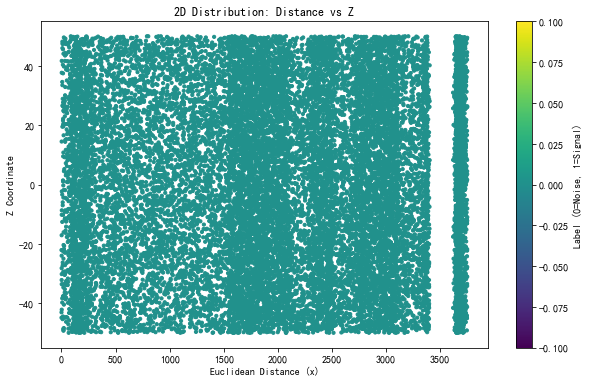

('Forest-Cedar2', 1) 24576


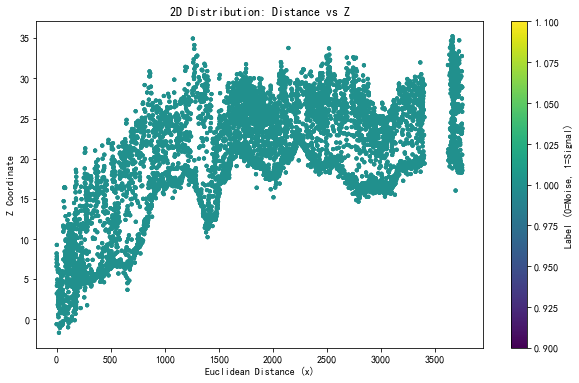

('Forest-Cedar4', 0) 21617


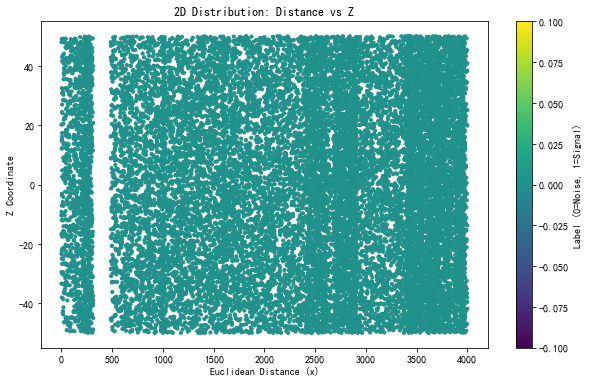

('Forest-Cedar4', 1) 26196


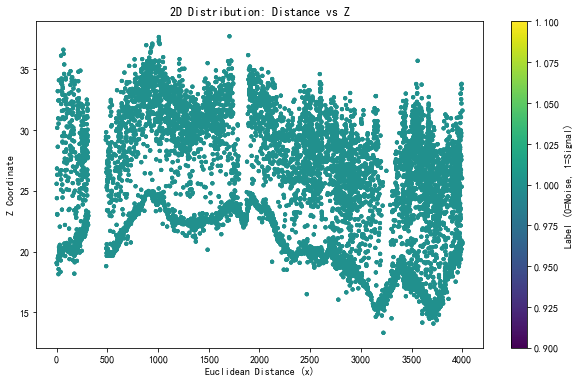

('Forest-SERC1', 0) 11763


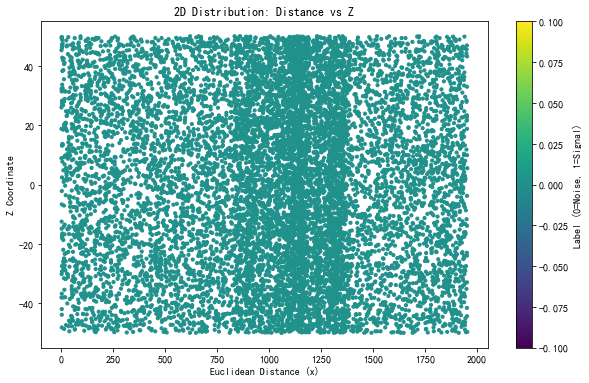

('Forest-SERC1', 1) 13713


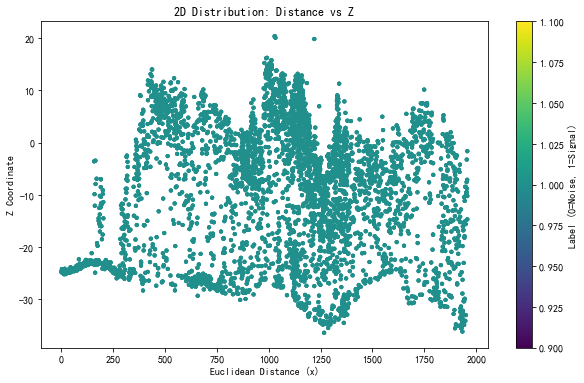

('Forest-SERC3', 0) 13203


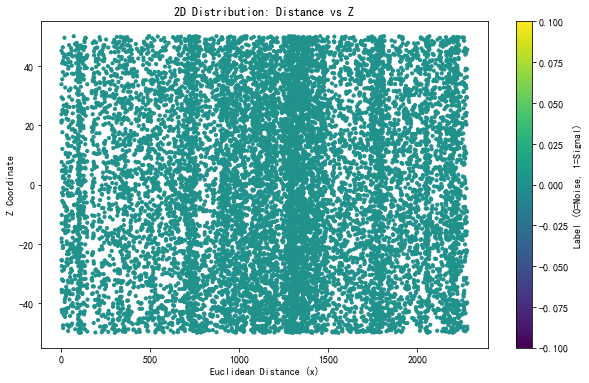

('Forest-SERC3', 1) 15564


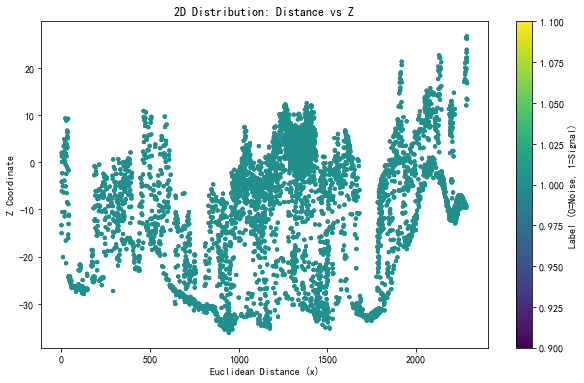

('Forest-SERC5', 0) 19072


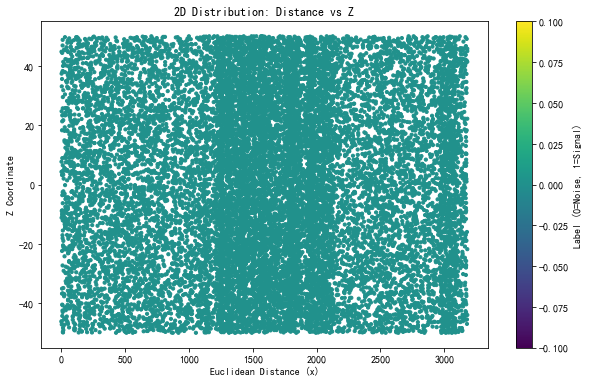

('Forest-SERC5', 1) 22269


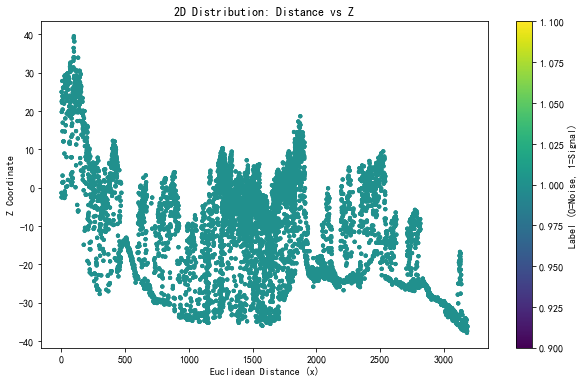

('ICE-Flight 6', 0) 374330


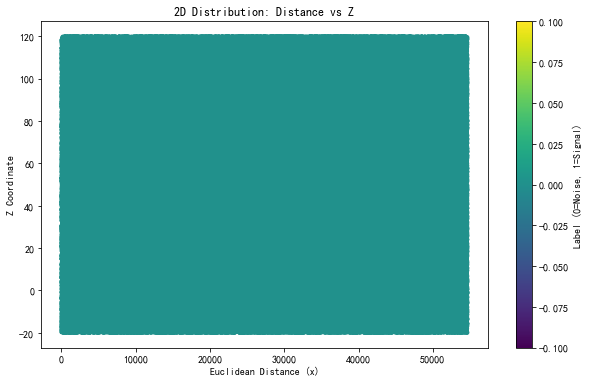

('ICE-Flight 6', 1) 50939


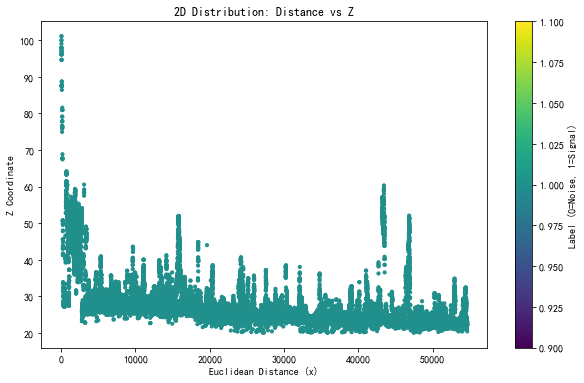

('ICE-Flight 7', 0) 1664145


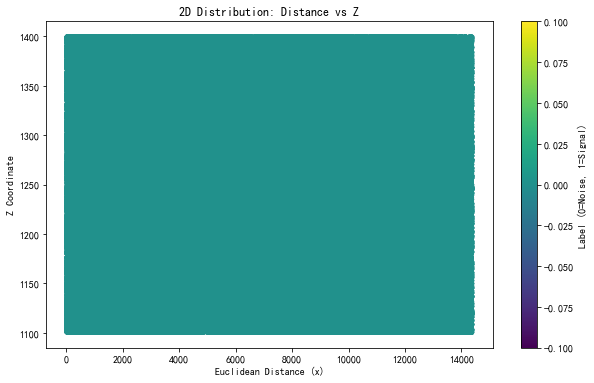

('ICE-Flight 7', 1) 487546


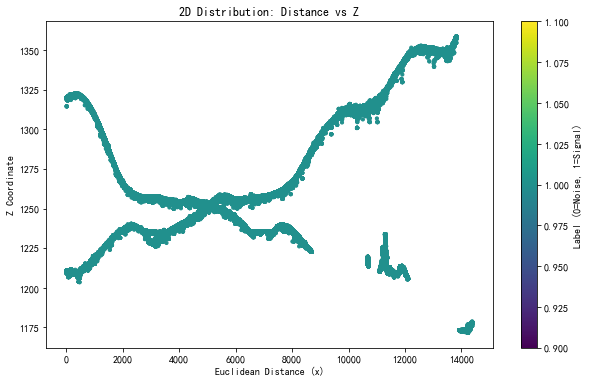

,x,z,ID,label,region
615036,0.000000,1209.339966,20,1,ICE-Flight 7
615037,0.000000,1209.510010,21,1,ICE-Flight 7
615038,0.000000,1210.219971,22,1,ICE-Flight 7
615039,0.000000,1210.130005,23,1,ICE-Flight 7
615040,0.000000,1209.510010,24,1,ICE-Flight 7
...,...,...,...,...,...
2766662,14385.781250,1178.280029,307532,1,ICE-Flight 7
2766669,14386.498047,1178.380005,307539,1,ICE-Flight 7
2766689,14387.202148,1178.290039,307559,1,ICE-Flight 7
2766690,14387.202148,1178.270020,307560,1,ICE-Flight 7


('day', 0) 4279858


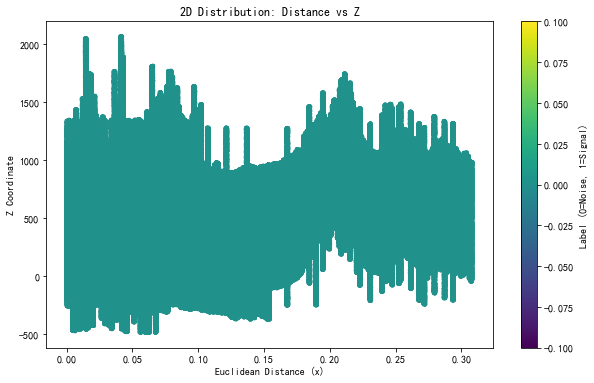

('day', 1) 258964


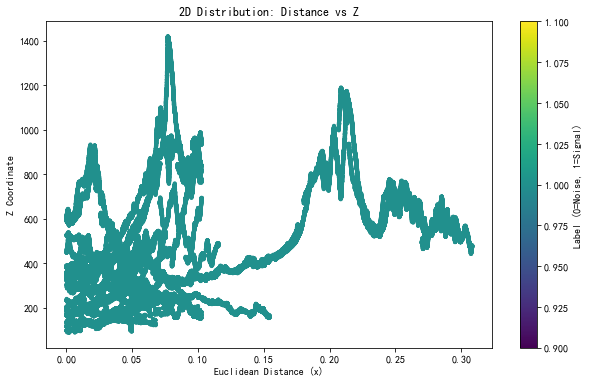

('night', 0) 23114


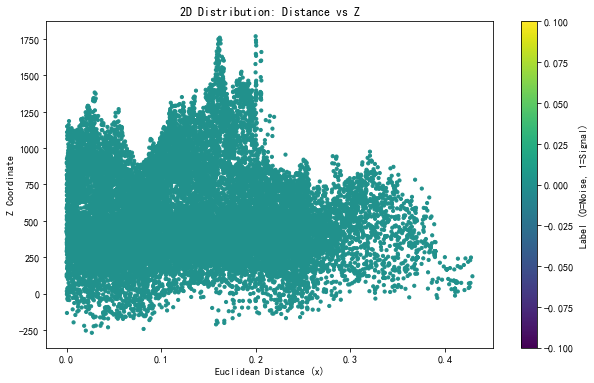

('night', 1) 484227


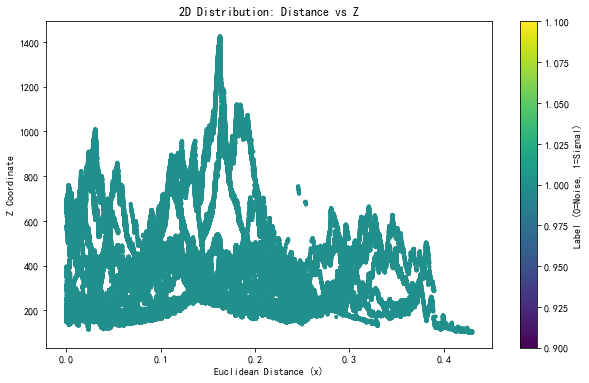

In [11]:
g

,x,z,ID,label,region
4538822,0.000000,190.841904,1,1,night
4538824,0.000096,194.660095,3,1,night
4538825,0.000109,194.560593,4,1,night
4538826,0.000128,194.444595,5,1,night
4538827,0.000180,194.737000,6,1,night
...,...,...,...,...,...
5046157,0.256862,331.066010,9816,1,night
5046158,0.256881,330.924500,9817,1,night
5046159,0.256920,331.093903,9818,1,night
5046160,0.256926,331.205994,9819,1,night


('day', 0) 148907


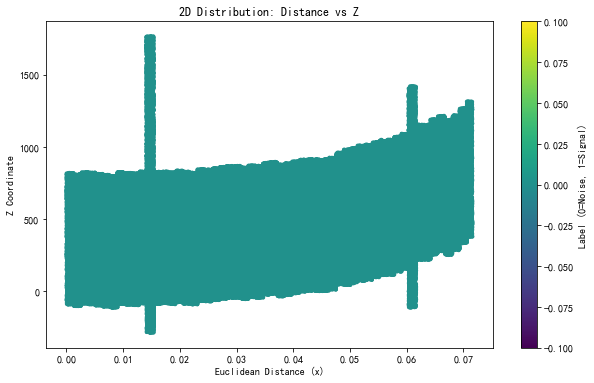

('day', 1) 5328


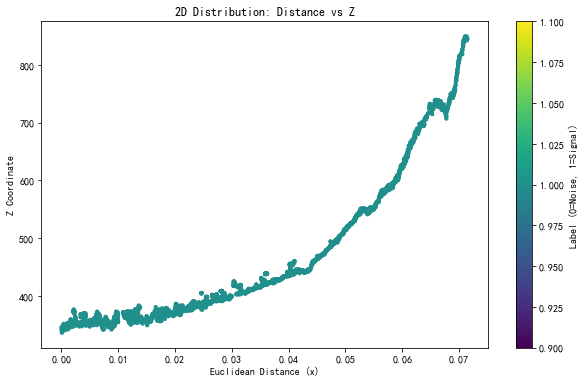

2024-12-24 14:15:09.333288: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "point_net_plus_plus"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 set_abstraction (SetAbstrac  multiple                 12672     
 tion)                                                           
                                                                 
 set_abstraction_1 (SetAbstr  multiple                 66048     
 action)                                                         
                                                                 
 set_abstraction_2 (SetAbstr  multiple                 263168    
 action)                                                         
                                                                 
 feature_propagation (Featur  multiple                 394240    
 ePropagation)                                                   
                                                                 
 feature_propagation_1 (Feat  multiple         

In [ ]:
# 模拟数据输入
batch_size = 4
num_points = 512
num_features = 2  # 只有 x 和 z 坐标
x = tf.random.normal((batch_size, num_points, num_features))


In [4]:
x.shape

TensorShape([4, 512, 2])

In [5]:
predictions = model(x)

In [6]:

# 模型预测
print(predictions.shape)  # (batch_size, num_points, num_classes)


(4, 512, 2)


In [1]:
# v1版本
def get_ball_query(self, point_cloud, radius, nsample):
        """
        获取球形邻域内的点的索引
        point_cloud: 输入的点云数据，形状为 (batch_size, num_points, 2)
        radius: 邻域半径
        nsample: 每个点采样的最大点数
        """
        batch_size, num_points, _ = point_cloud.shape
        # 计算每对点之间的欧氏距离
        dists = tf.norm(point_cloud[:, :, None, :] - point_cloud[:, None, :, :], axis=-1)  # (batch_size, num_points, num_points)
        
        # 找出在指定半径范围内的点的索引
        ball_query_indices = tf.where(dists <= radius)  # (num_valid_pairs, 3), 3 is (batch_idx, point_idx_1, point_idx_2)
        
        # 创建一个邻居索引数组，形状为 (batch_size, num_points, nsample)
        ball_indices = []
        
        for i in range(batch_size):
            point_indices_list = []
            
            # 获取每个点的所有邻居
            for j in range(num_points):
                # 获取当前点的所有邻居索引
                neighbors = ball_query_indices[ball_query_indices[:, 0] == i]  # 当前批次所有点的邻居索引
                neighbors_of_point_j = neighbors[neighbors[:, 1] == j][:, 2]  # 获取当前点 j 的邻居索引
                
                # 获取邻居数量
                num_neighbors = tf.shape(neighbors_of_point_j)[0]
                
                # 如果邻居数量少于 nsample，随机填充
                if num_neighbors < nsample:
                    # 如果邻居数量少于 nsample，随机重复邻居直到补充到 nsample
                    additional_indices = tf.random.shuffle(neighbors_of_point_j)
                    # 将 neighbors_of_point_j 拼接到一起，直到达到 nsample 个邻居
                    neighbors_of_point_j = tf.tile(additional_indices, [nsample // num_neighbors + 1])[:nsample]
                elif num_neighbors > nsample:
                    # 如果邻居数量大于 nsample，选择前 nsample 个邻居
                    neighbors_of_point_j = neighbors_of_point_j[:nsample]
                
                # 确保每个点都有 nsample 个邻居
                point_indices_list.append(neighbors_of_point_j)
            
            # 将每个点的邻居索引堆叠到一起，形成当前批次的所有点的邻居索引
            ball_indices.append(tf.stack(point_indices_list, axis=0))  # shape: (num_points, nsample)
        
        # 转换为 (batch_size, num_points, nsample) 的形状
        ball_indices = tf.stack(ball_indices, axis=0)  # shape: (batch_size, num_points, nsample)
        return ball_indices
        